# **Sentiment Analysis for Movie Dataset**

In [2]:
!pip install six


In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import glob
from bs4 import BeautifulSoup
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix,classification_report

from joblib import dump, load

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
trainPos = glob.glob('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB/aclImdb/train/pos/*.txt')
trainNeg = glob.glob('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB/aclImdb/train/neg/*.txt')
print("total reviews for training : {}".format(len(trainPos)+len(trainNeg)))
testPos = glob.glob('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB/aclImdb/test/pos/*.txt')
testNeg = glob.glob('/content/drive/MyDrive/Sentiment-Analysis/aclIMDB/aclImdb/test/neg/*.txt')
print("total reviews for testing : {}".format(len(testPos)+len(testNeg)))

total reviews for training : 15327
total reviews for testing : 25000


**Let's convert the text files into dataframe for further processing.**

In [5]:
def extractText(folder):
    allText = []
    textFiles = []
    for fileName in folder:
        with open(fileName,'r') as txtfile:
            text = txtfile.read()
            text = text.lower()
            cleanText = BeautifulSoup(text,"html.parser").text
            allText.append(cleanText)
            textFiles.append(fileName)
    return allText, textFiles

In [6]:
trainPosText,trainPosFiles = extractText(trainPos)
trainNegText,trainNegFiles = extractText(trainNeg)
testPosText,testPosFiles = extractText(testPos)
testNegText,testNegFiles = extractText(testNeg)

#for positive training files
dfTrainPos = pd.DataFrame(trainPosText,columns=['reviews'])
dfTrainPos['filename'] = trainPosFiles

#for negative training files
dfTrainNeg = pd.DataFrame(trainNegText,columns=['reviews'])
dfTrainNeg['filename'] = trainNegFiles

#for positive testing files
dfTestPos = pd.DataFrame(testPosText,columns=['reviews'])
dfTestPos['filename'] = testPosFiles

#for negative testing files
dfTestNeg = pd.DataFrame(testNegText,columns=['reviews'])
dfTestNeg['filename'] = testNegFiles

KeyboardInterrupt: 

In [10]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def read_file(path):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    except:
        return ""

def extractTextToDF(file_paths):
    with ThreadPoolExecutor(max_workers=16) as executor:  # adjust threads
        texts = list(executor.map(read_file, file_paths))
    return pd.DataFrame({
        "reviews": texts,
        "filename": [os.path.basename(p) for p in file_paths]
    })

# Now directly get DataFrames
dfTrainPos = extractTextToDF(trainPos)
dfTrainNeg = extractTextToDF(trainNeg)
dfTestPos  = extractTextToDF(testPos)
dfTestNeg  = extractTextToDF(testNeg)


In [11]:
dfTrainPos.head(5)

,reviews,filename
0,"I was on France, around March 05, and I love t...",11645_8.txt
1,"This movie, even though is about one of the mo...",11646_10.txt
2,I can give you four reasons to see this movie:...,11647_8.txt
3,"There are people claiming this is another ""bad...",11648_9.txt
4,"What an absolutely stunning movie, if you have...",11649_10.txt


In [12]:
dfTrainNeg.head(5)

,reviews,filename
0,"Christ, oh Christ... One watches stunned, incr...",9100_1.txt
1,"This movie was like ""The Disney Channel after ...",9101_1.txt
2,I was willing to go with the original _Cruel I...,9102_1.txt
3,Alright normally i am not as harsh on sequels ...,9103_1.txt
4,<br /><br />When I first started watching this...,9104_2.txt


In [13]:
dfTestPos.head(5)

,reviews,filename
0,This movie is everything a Tenacious D fans ca...,9100_10.txt
1,I loved this movie!! Jack Black and Kyle Gass ...,9101_10.txt
2,I absolutely loved every minute of this film. ...,9102_10.txt
3,This movie is very silly and very funny. You c...,9103_10.txt
4,"(Very mild spoilers; a basic plot outline, no ...",9104_7.txt


In [14]:
dfTestNeg.head(5)

,reviews,filename
0,Alain Resnais directs three parallel stories t...,9100_2.txt
1,"This film tries very hard to be an ""action"" fi...",9101_2.txt
2,My friends and I rented this movie mistaking i...,9102_1.txt
3,all i can say about this film is to read the b...,9103_1.txt
4,This movie was bad on so many levels. The writ...,9104_2.txt


**let's build the wordcloud of the training data set initially for observing the frequency of words as well as their importance.**

In [15]:
stpwords = list(STOPWORDS)
stpwords.extend(stopwords.words('english'))
stpwords.extend(['movie','movies','film','films',
                 'actor','actress','cinema',
                 'story','br','role','dramas','drama',
                 'characters','character','director'])
stpwords = set(stpwords)

In [16]:
def wordCloud(text):
    wordcloud = WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).generate(text)
    return wordcloud

In [17]:
def plotWordCloud(wordcloud):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [18]:
wordTrainPos = " ".join(review.strip() for review in dfTrainPos.reviews)
wordTrainNeg = " ".join(review.strip() for review in dfTrainNeg.reviews)

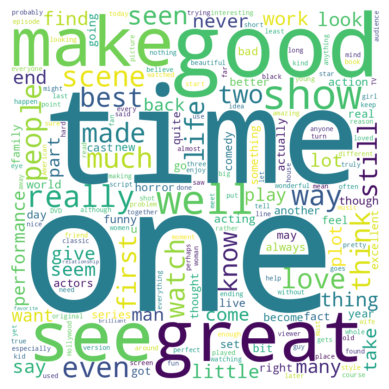

In [19]:
wordcloudPos = wordCloud(wordTrainPos)
plotWordCloud(wordcloudPos)

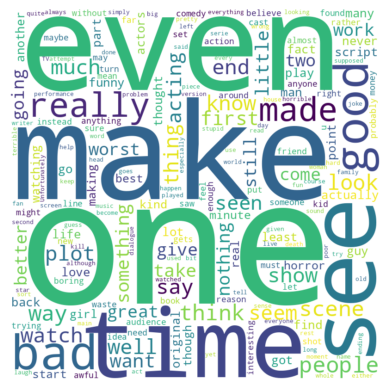

In [20]:
wordcloudNeg = wordCloud(wordTrainNeg)
plotWordCloud(wordcloudNeg)

In [22]:
wordcloudPos.to_file('/content/wordcloudpos.png')

In [23]:
wordcloudNeg.to_file('/content/wordcloudNeg.png')

**The wordcloud shown here shows the most common words that appear in the texts. However, the words shown here clearly donot define the sentiments of positive or negative reviews.**

**Let's see the weights of the words given by count vectorizer and visualize it.**

In [24]:
stop_words = stopwords.words('english')
cntVectorizerPos = CountVectorizer(binary=False, stop_words=list(stpwords), min_df=5, max_df=0.90,max_features=40000)
cntVectorizerNeg = CountVectorizer(binary=False, stop_words=list(stpwords), min_df=5, max_df=0.90,max_features=40000)
dataTrainPos = cntVectorizerPos.fit_transform(dfTrainPos['reviews'])
dataTrainNeg = cntVectorizerNeg.fit_transform(dfTrainNeg['reviews'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  warnings.warn(


In [26]:
featureNamesPos = cntVectorizerPos.get_feature_names_out()
featureNamesNeg = cntVectorizerNeg.get_feature_names_out()


In [27]:
def getTopFeatures(features,n,featuresName):
    dictionary = {}
    featuresSum = features.sum(axis=0)[0,:]
    featuresSum = np.squeeze(np.asarray(featuresSum))
    sortedIndices = np.argsort(-1*featuresSum)[0:n]
    for index in sortedIndices:
        dictionary[featuresName[index]]=featuresSum[index]
    return dictionary

In [28]:
dictionaryPos = getTopFeatures(dataTrainPos,500,featureNamesPos)
dictionaryNeg = getTopFeatures(dataTrainNeg,500,featureNamesNeg)

In [29]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

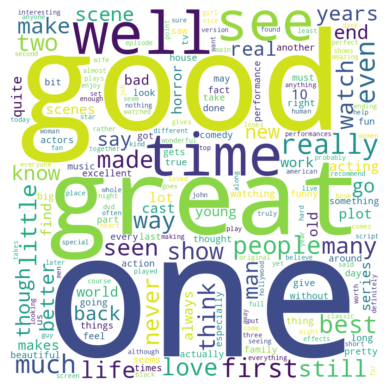

In [30]:
wordcloudPos = wordCloudFromFrequency(dictionaryPos)
plotWordCloud(wordcloudPos)

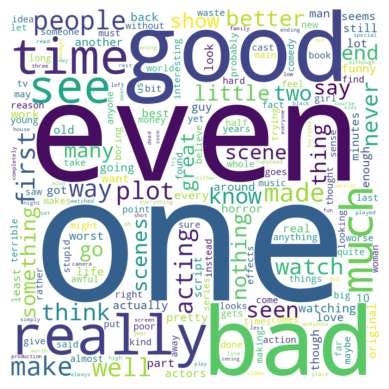

In [31]:
wordcloudNeg = wordCloudFromFrequency(dictionaryNeg)
plotWordCloud(wordcloudNeg)

In [32]:
wordcloudPos.to_file('/content/wordcloudPoscount.png')
wordcloudNeg.to_file('/content/wordcloudNegcount.png')

**As seen from the wordcloud above, we observe top 500 most repetitive words and they too may not represent the words that are important in classifying the sentiments.**

**let's use some of the classical approaches through which we can know the type of words that are used in classifying sentiments. let's update the label by our own. The positive sentiments are given label 1 and negative sentiments are given label 0.**

In [34]:
dfTrainPos['label'] = 1
dfTrainNeg['label'] = 0
dfTestPos['label'] = 1
dfTestNeg['label'] = 0
trainDf = pd.concat([dfTrainPos, dfTrainNeg], ignore_index=True)
trainDf = trainDf.sample(frac=1)  # shuffle

testDf = pd.concat([dfTestPos, dfTestNeg], ignore_index=True)
testDf = testDf.sample(frac=1)

trainDf.head(5)

,reviews,filename,label
8549,I absolutely adore the book written by Robin K...,5250_4.txt,0
9732,"""Piece is Cake"" is defeatist, revisionist hist...",4515_1.txt,0
15106,A good deal of running around. A badly conceiv...,10251_3.txt,0
3432,The Lack of content in this movie amazed me th...,9646_1.txt,0
65,This is a great movie. Some will disagree with...,11703_9.txt,1


**We are considering the words that are present in at least 5 documents and rejecting the words that are present in 95% of the text files.**

In [36]:
countVect = CountVectorizer(binary=False, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             min_df=5,max_df=0.95)
trainFeatures = countVect.fit_transform(trainDf.reviews)
features = countVect.get_feature_names_out()

In [37]:
print("the number of words taken for training sentiments: {}".format(len(features)))

the number of words taken for training sentiments: 20433


**lets choose the best hyperparameters.**

In [38]:
params = {
    'max_depth':[5,6,7],
    'max_features':[0.9, 1.0],
    'n_estimators':[10,15]
}

rfClassifier = RandomForestClassifier(random_state=6,n_jobs=-1)
gridSearch = GridSearchCV(rfClassifier, params,verbose=3,n_jobs=-1)
gridSearch.fit(trainFeatures, trainDf.label)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForestClassifier(max_depth=7, max_features=1.0, n_estimators=15,
                       n_jobs=-1, random_state=6)


**For the given range of parameters, the best hyperparameters are given and best estimator is obtained.**

the accuracy score for training set : 0.8530697461995171
the accuracy score for testing set : 0.58744
[[12250   250]
 [10064  2436]]
              precision    recall  f1-score   support

           0       0.55      0.98      0.70     12500
           1       0.91      0.19      0.32     12500

    accuracy                           0.59     25000
   macro avg       0.73      0.59      0.51     25000
weighted avg       0.73      0.59      0.51     25000



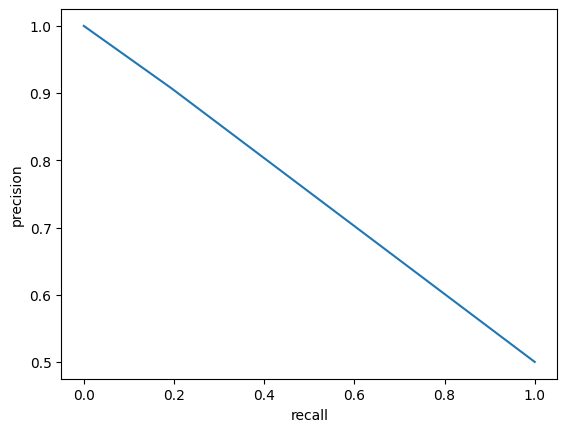

In [40]:
bestClassifier = gridSearch.best_estimator_
dump(bestClassifier, '/content/rfClassifier.joblib')

loadedModel = load('/content/rfClassifier.joblib')
rfTrainPredict = loadedModel.predict(trainFeatures)
score = accuracy_score(trainDf.label, rfTrainPredict)
print("the accuracy score for training set : {}".format(score))

# for testing data
testFeatures = countVect.transform(testDf.reviews)
rfTestPredict = loadedModel.predict(testFeatures)
score = accuracy_score(testDf.label, rfTestPredict)
print("the accuracy score for testing set : {}".format(score))
print(confusion_matrix(testDf.label,rfTestPredict))
print(classification_report(testDf.label,rfTestPredict))
precision, recall, threshold = precision_recall_curve(testDf.label,rfTestPredict)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [41]:
featureImp = loadedModel.feature_importances_
indices = np.argsort(-featureImp)

trainWords = {}
for index in indices[0:100]:
    trainWords[features[index]] = featureImp[index]

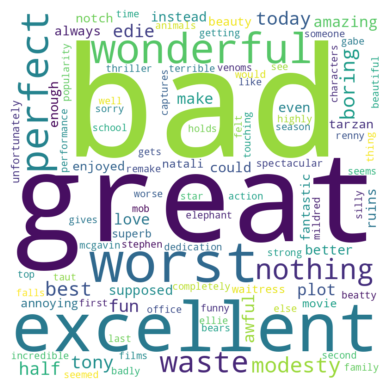

In [42]:
wordcloudAfterClassifier = wordCloudFromFrequency(trainWords)
plotWordCloud(wordcloudAfterClassifier)

In [43]:
wordcloudAfterClassifier.to_file('/content/wordcloudafterclassifier.png')

**The wordcloud above shows that after training, we have obtained the most important top 100 words that are used for classification. The words are mostly the adjective describing the positive and negative sentiments.**

In [44]:
bestModel = loadedModel.estimators_[9]

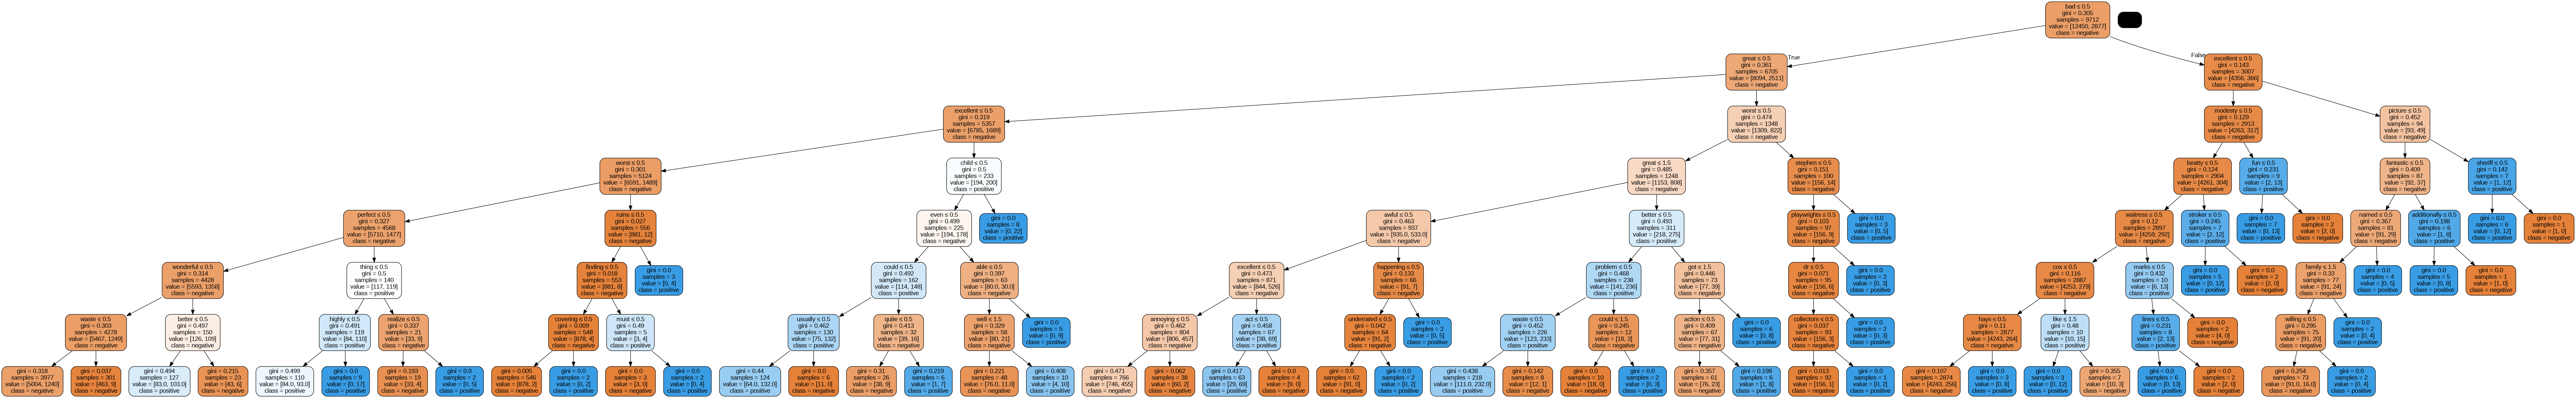

In [45]:
dot_data = StringIO()
export_graphviz(bestModel, out_file=dot_data, feature_names=features,
               class_names=['negative','positive'], filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [46]:
graph.write_png('/content/decisionTree.png')

True

**The decision tree above is one of the sections of random forest which shows the branching to positive and negative sentiments based on the occurrence of words.**

## Logistic regression for positive and negative words

In [47]:
params = {
    'C':[0.07,0.09,0.1,0.2,0.3,0.5,1]
}

logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1)
gridSearch = GridSearchCV(logisticModel, params,verbose=3,n_jobs=-1)
gridSearch.fit(trainFeatures, trainDf.label)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
LogisticRegression(C=0.09, n_jobs=-1, random_state=6)


In [48]:
posEg = {}
negEg = {}
bestModel = gridSearch.best_estimator_
indicesForPosEg = np.argsort(-1*bestModel.coef_)[:,0:100][0]
for i in indicesForPosEg[0:100]:
    posEg[features[i]] = bestModel.coef_[0,i]
indicesForNegEg = np.argsort(bestModel.coef_)[:,0:100][0]
for i  in indicesForNegEg[0:100]:
    negEg[features[i]] = -1*bestModel.coef_[0,i]

the accuracy of training set is :0.9820578064852874
the accuracy of testing set is :0.76496
[[12200   300]
 [ 5576  6924]]
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     12500
           1       0.96      0.55      0.70     12500

    accuracy                           0.76     25000
   macro avg       0.82      0.76      0.75     25000
weighted avg       0.82      0.76      0.75     25000



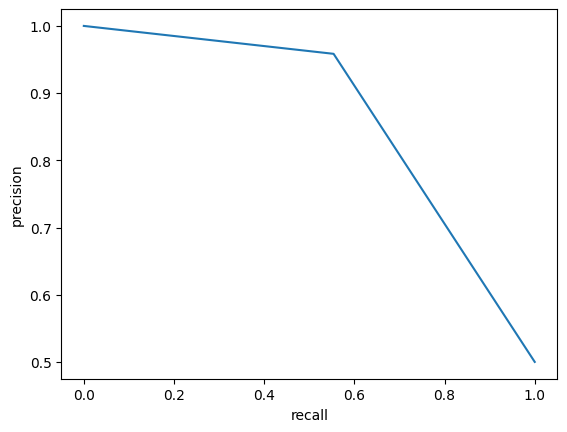

In [50]:
bestModel = gridSearch.best_estimator_
dump(bestModel, '/content/logisticRegression.joblib')

loadedModel = load('/content/logisticRegression.joblib')

trainPredictLR = loadedModel.predict(trainFeatures)
testPredictLR = loadedModel.predict(testFeatures)

accuracyLRtrain = accuracy_score(trainDf.label, trainPredictLR)
accuracyLRtest = accuracy_score(testDf.label, testPredictLR)
print("the accuracy of training set is :{}".format(accuracyLRtrain))
print("the accuracy of testing set is :{}".format(accuracyLRtest))
print(confusion_matrix(testDf.label,testPredictLR))
print(classification_report(testDf.label,testPredictLR))
precision, recall, threshold = precision_recall_curve(testDf.label,testPredictLR)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

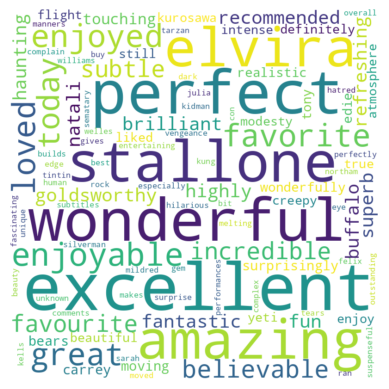

In [51]:
wordcloudLogRegPos = wordCloudFromFrequency(posEg)
plotWordCloud(wordcloudLogRegPos)

In [52]:
wordcloudLogRegPos.to_file('/content/wordcloudLogRegressionPos.png')

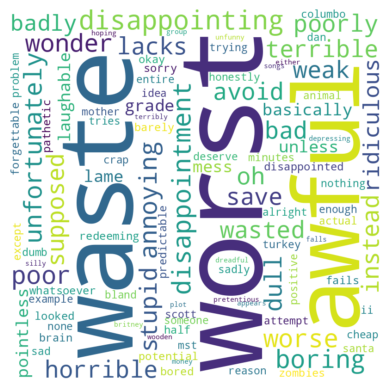

In [53]:
wordcloudLogRegNeg = wordCloudFromFrequency(negEg)
plotWordCloud(wordcloudLogRegNeg)

In [54]:
wordcloudLogRegNeg.to_file('/content/wordcloudLogRegressionNeg.png')

**The logistic regression showed the higher accurracy for classification and the wordclouds represent the important postive as well as negative words used for classification.**